In [1]:
!unzip Images.zip

'unzip'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [2]:
!unzip Airplanes_Annotations.zip

'unzip'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [3]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Using TensorFlow backend.
d:\apps\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\apps\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\apps\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\apps\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing

In [4]:
path = "Images"
annot = "Airplanes_Annotations"

42845.jpg
img filename Images\42845.jpg
df filename Airplanes_Annotations\42845.csv


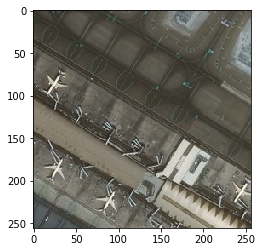

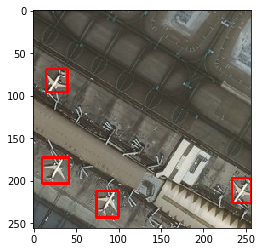

In [5]:
# 견본 이미지와 CSV로 어떤 정보가 있는지 확인
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        
        print("img filename", os.path.join(path,filename))
        print("df filename", os.path.join(annot,i))
        
        # show original image
        plt.imshow(img)

        # data frame 에서 네모 좌표값을 획득하여, 이미지 위에 그려준다
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)

        plt.figure()
        plt.imshow(img)
        break

In [6]:
# selective search 테스트
# selective search 오브젝트 생성
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

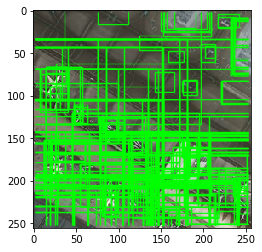

In [7]:
# selective search 사용법 확인
im = cv2.imread(os.path.join(path,"42845.jpg"))

ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
# 오브젝트 찾기 작업
rects = ss.process()
imOut = im.copy()

for i, rect in (enumerate(rects)):
    # 찾은 오브젝트들 반복하면서 네모를 그려준다
    x, y, w, h = rect
    #print(x,y,w,h)
    #imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()

plt.imshow(imOut)

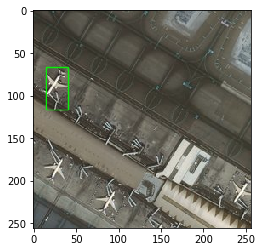

In [8]:
# test code
# selective search로 찾아낸 네모중에 1개를 그려본다.

imOut1 = im.copy()

rrr = rects[14]
x1, y1, w1, h1 = rrr
cv2.rectangle(imOut1, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut1)

In [9]:
train_images=[]
train_labels=[]

In [10]:
# iou 중첩도 계산 (데이터 셋과 비교하여, 비행기 인지 찾기)
# https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # get Minimum size box
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [11]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [12]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            # load dataset
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]

            # get airplain location
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})

            #print(gtvalues) # airplain location value
                
            # selective search process
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()

            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0

            for e,result in enumerate(ssresults):
                # selective search는 2000개 정도의 ragion을 생성함다 (네모)
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        #print(x,y,w,h)
                        
                        # gtvalues : any one in csv data
                        # x, w, y, h : any one in selective search data
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})

                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter < 30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)

        continue

17 airplane_001.jpg
inside
18 airplane_002.jpg
19 airplane_003.jpg
20 airplane_004.jpg
inside
21 airplane_005.jpg
inside
22 airplane_006.jpg
23 airplane_007.jpg
inside
24 airplane_008.jpg
25 airplane_009.jpg
26 airplane_010.jpg
27 airplane_011.jpg
28 airplane_012.jpg
inside
29 airplane_013.jpg
30 airplane_014.jpg
31 airplane_015.jpg
32 airplane_016.jpg
33 airplane_017.jpg
34 airplane_018.jpg
35 airplane_019.jpg
36 airplane_020.jpg
37 airplane_021.jpg
38 airplane_022.jpg
39 airplane_023.jpg
40 airplane_024.jpg
41 airplane_025.jpg
42 airplane_026.jpg
43 airplane_027.jpg
44 airplane_028.jpg
45 airplane_029.jpg
46 airplane_030.jpg
47 airplane_031.jpg
48 airplane_032.jpg
49 airplane_033.jpg
50 airplane_034.jpg
51 airplane_035.jpg
52 airplane_036.jpg
53 airplane_037.jpg
54 airplane_038.jpg
55 airplane_039.jpg
56 airplane_040.jpg
57 airplane_041.jpg
inside
58 airplane_042.jpg
59 airplane_043.jpg
60 airplane_044.jpg
61 airplane_045.jpg
inside
62 airplane_046.jpg
63 airplane_047.jpg
64 airplane

396 airplane_380.jpg
397 airplane_381.jpg
398 airplane_382.jpg
inside
399 airplane_383.jpg
inside
400 airplane_384.jpg
401 airplane_385.jpg
inside
402 airplane_386.jpg
403 airplane_387.jpg
404 airplane_388.jpg
inside
405 airplane_389.jpg
406 airplane_390.jpg
407 airplane_391.jpg
408 airplane_392.jpg
409 airplane_393.jpg
410 airplane_394.jpg
411 airplane_395.jpg
412 airplane_396.jpg
413 airplane_397.jpg
414 airplane_398.jpg
415 airplane_399.jpg
416 airplane_400.jpg
417 airplane_401.jpg
418 airplane_402.jpg
419 airplane_403.jpg
420 airplane_404.jpg
421 airplane_405.jpg
422 airplane_406.jpg
423 airplane_407.jpg
424 airplane_408.jpg
425 airplane_409.jpg
426 airplane_410.jpg
427 airplane_411.jpg
428 airplane_412.jpg
429 airplane_413.jpg
430 airplane_414.jpg
431 airplane_415.jpg
432 airplane_416.jpg
433 airplane_417.jpg
434 airplane_418.jpg
435 airplane_419.jpg
inside
436 airplane_420.jpg
437 airplane_421.jpg
438 airplane_422.jpg
439 airplane_423.jpg
440 airplane_424.jpg
441 airplane_425.jpg

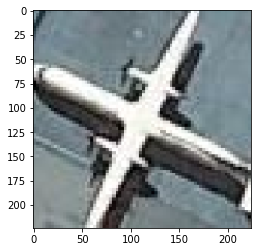

In [13]:
# 구분해낸 데이터에서 labels갑과 image가 일치하는지 확인
# labels 값이 1이면 이미지가 비행기이다!

X_new = np.array(train_images)
y_new = np.array(train_labels)

for i,iter in enumerate(train_images):
    if train_labels[i] == 1:    # 라벨값이 참이면
        plt.imshow(iter)        # 이미지 확인
        break

In [14]:
print("total train : ", y_new.size)
print("true train : ", (y_new == 1).sum())
print("false train : ", (y_new == 0).sum())


print((y_new == 0).sum() / y_new.size)
print((y_new == 1).sum() / y_new.size)

total train :  30229
true train :  9289
false train :  20940
0.6927122961394687
0.3072877038605313


In [15]:
# 데이터의 shape 확인
print(X_new.shape)
print(y_new.shape)

(30229, 224, 224, 3)
(30229,)


In [16]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

# 모델 만들기 1 - 평범한 CNN 모델
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_new.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

In [45]:
# 모델 만들기 2 - VGG 모델 밴치마킹 에서 2개정도 삭제

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_new.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
#model.add(Conv2D(512, (3, 3), padding='same'))
#model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_11 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_12 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 128)    

# 모델 만들기 3 - VGG 모델 밴치마킹

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=X_new.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

In [47]:
for layers in (model.layers)[:15]:
    print(layers)
    layers.trainable = False

In [48]:
X= model.layers[-2].output

In [49]:
from keras.optimizers import Adam
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

In [50]:

#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
# 모델 구성 확인
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_11 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_12 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 128)    

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [53]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [54]:
# 값을 binary화 시킴
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [55]:
# train set과 test set으로 구분
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [56]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(27206, 224, 224, 3) (3023, 224, 224, 3) (27206, 2) (3023, 2)


In [57]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
#, batch_size=1
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [58]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [59]:
checkpoint = ModelCheckpoint("vgg_custom_models.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [60]:
hist = model.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, workers=1, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

#max_queue_size=256, 

Epoch 1/1000
10/10 [==============================] - 5s 467ms/step - loss: 275.6323 - accuracy: 0.5156 - val_loss: 0.6396 - val_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 0.63962, saving model to vgg_custom_models.h5
Epoch 2/1000
10/10 [==============================] - 2s 225ms/step - loss: 0.7574 - accuracy: 0.6375 - val_loss: 0.5596 - val_accuracy: 0.7188

Epoch 00002: val_loss improved from 0.63962 to 0.55962, saving model to vgg_custom_models.h5
Epoch 3/1000
10/10 [==============================] - 2s 224ms/step - loss: 0.6794 - accuracy: 0.6969 - val_loss: 0.6790 - val_accuracy: 0.7656

Epoch 00003: val_loss did not improve from 0.55962
Epoch 4/1000
10/10 [==============================] - 3s 273ms/step - loss: 0.6803 - accuracy: 0.7063 - val_loss: 0.6583 - val_accuracy: 0.7969

Epoch 00004: val_loss did not improve from 0.55962
Epoch 5/1000
10/10 [==============================] - 3s 304ms/step - loss: 0.6740 - accuracy: 0.6812 - val_loss: 0.6647 - val_accurac

Epoch 42/1000
10/10 [==============================] - 3s 321ms/step - loss: 0.6091 - accuracy: 0.7031 - val_loss: 0.5950 - val_accuracy: 0.6719

Epoch 00042: val_loss did not improve from 0.51782
Epoch 43/1000
10/10 [==============================] - 3s 319ms/step - loss: 0.6293 - accuracy: 0.6812 - val_loss: 0.4895 - val_accuracy: 0.7656

Epoch 00043: val_loss improved from 0.51782 to 0.48950, saving model to vgg_custom_models.h5
Epoch 44/1000
10/10 [==============================] - 3s 313ms/step - loss: 0.5881 - accuracy: 0.7281 - val_loss: 0.6215 - val_accuracy: 0.6562

Epoch 00044: val_loss did not improve from 0.48950
Epoch 45/1000
10/10 [==============================] - 3s 327ms/step - loss: 0.6152 - accuracy: 0.6969 - val_loss: 0.6216 - val_accuracy: 0.7031

Epoch 00045: val_loss did not improve from 0.48950
Epoch 46/1000
10/10 [==============================] - 3s 322ms/step - loss: 0.6564 - accuracy: 0.6469 - val_loss: 0.6993 - val_accuracy: 0.6719

Epoch 00046: val_loss di

10/10 [==============================] - 4s 371ms/step - loss: 0.6488 - accuracy: 0.6562 - val_loss: 0.5705 - val_accuracy: 0.6875

Epoch 00083: val_loss did not improve from 0.46691
Epoch 84/1000
10/10 [==============================] - 3s 346ms/step - loss: 0.6627 - accuracy: 0.6375 - val_loss: 0.6700 - val_accuracy: 0.6875

Epoch 00084: val_loss did not improve from 0.46691
Epoch 85/1000
10/10 [==============================] - 4s 363ms/step - loss: 0.6247 - accuracy: 0.6844 - val_loss: 0.6212 - val_accuracy: 0.6719

Epoch 00085: val_loss did not improve from 0.46691
Epoch 86/1000
10/10 [==============================] - 4s 378ms/step - loss: 0.6101 - accuracy: 0.7063 - val_loss: 0.6921 - val_accuracy: 0.6562

Epoch 00086: val_loss did not improve from 0.46691
Epoch 87/1000
10/10 [==============================] - 3s 288ms/step - loss: 0.6518 - accuracy: 0.6469 - val_loss: 0.5748 - val_accuracy: 0.7344

Epoch 00087: val_loss did not improve from 0.46691
Epoch 88/1000
10/10 [========


Epoch 00124: val_loss did not improve from 0.46691
Epoch 125/1000
10/10 [==============================] - 3s 302ms/step - loss: 0.5867 - accuracy: 0.7312 - val_loss: 0.6213 - val_accuracy: 0.7500

Epoch 00125: val_loss did not improve from 0.46691
Epoch 126/1000
10/10 [==============================] - 3s 305ms/step - loss: 0.6308 - accuracy: 0.6750 - val_loss: 0.5425 - val_accuracy: 0.7656

Epoch 00126: val_loss did not improve from 0.46691
Epoch 127/1000
10/10 [==============================] - 3s 307ms/step - loss: 0.6276 - accuracy: 0.6812 - val_loss: 0.5953 - val_accuracy: 0.7188

Epoch 00127: val_loss did not improve from 0.46691
Epoch 128/1000
10/10 [==============================] - 3s 303ms/step - loss: 0.6646 - accuracy: 0.6344 - val_loss: 0.6457 - val_accuracy: 0.7344

Epoch 00128: val_loss did not improve from 0.46691
Epoch 129/1000
10/10 [==============================] - 3s 293ms/step - loss: 0.6014 - accuracy: 0.7125 - val_loss: 0.6211 - val_accuracy: 0.7031

Epoch 001

10/10 [==============================] - 4s 395ms/step - loss: 0.6162 - accuracy: 0.6938 - val_loss: 0.6456 - val_accuracy: 0.6875

Epoch 00166: val_loss did not improve from 0.46691
Epoch 167/1000
10/10 [==============================] - 4s 362ms/step - loss: 0.6115 - accuracy: 0.7000 - val_loss: 0.5212 - val_accuracy: 0.7500

Epoch 00167: val_loss did not improve from 0.46691
Epoch 168/1000
10/10 [==============================] - 3s 347ms/step - loss: 0.6141 - accuracy: 0.6906 - val_loss: 0.5707 - val_accuracy: 0.7344

Epoch 00168: val_loss did not improve from 0.46691
Epoch 169/1000
10/10 [==============================] - 4s 360ms/step - loss: 0.6243 - accuracy: 0.6906 - val_loss: 0.5710 - val_accuracy: 0.7812

Epoch 00169: val_loss did not improve from 0.46691
Epoch 170/1000
10/10 [==============================] - 4s 356ms/step - loss: 0.5947 - accuracy: 0.7250 - val_loss: 0.6466 - val_accuracy: 0.6094

Epoch 00170: val_loss did not improve from 0.46691
Epoch 171/1000
10/10 [===

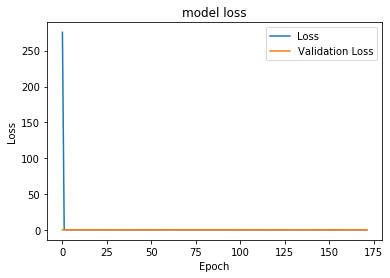

3023/3023 [==============================] - 14s 5ms/step
Test loss 0.6128415304660955
Test accuracy 0.6976513266563416
total train :  6046
true train :  3023
false train :  3023
0.5
0.5


<Figure size 432x288 with 0 Axes>

In [61]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

scores = model.evaluate(X_test, y_test, verbose=1)

print("Test loss", scores[0])
print("Test accuracy", scores[1])

print("total train : ", y_test.size)
print("true train : ", (y_test == 1).sum())
print("false train : ", (y_test == 0).sum())

print((y_test == 0).sum() / y_test.size)
print((y_test == 1).sum() / y_test.size)


615
not plane


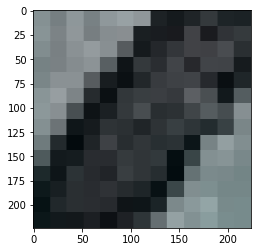

In [62]:
import random

print(random.randint(0, 1600))

#im = X_test[1600]
im = X_test[random.randint(0, 1600)]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model.predict(img)
if out[0][0] > out[0][1]:
    print("plane")
else:
    print("not plane")

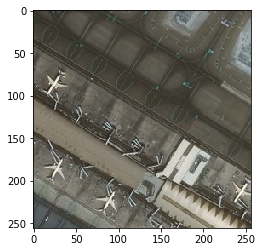

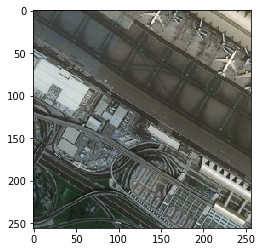

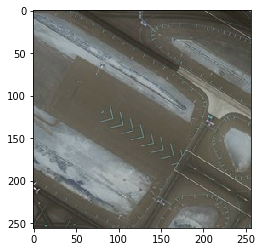

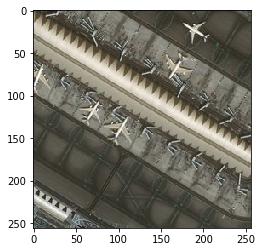

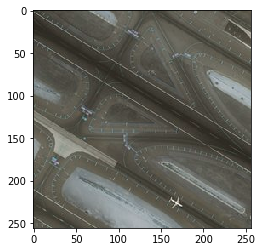

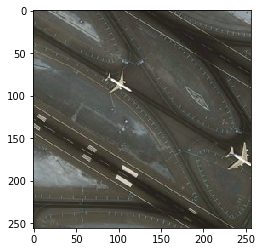

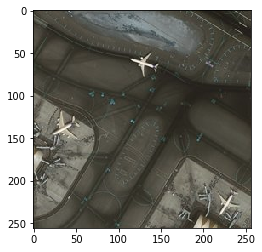

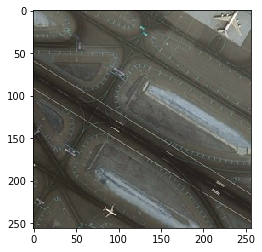

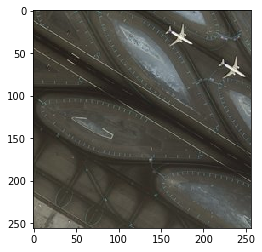

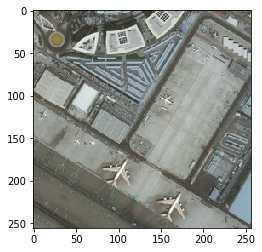

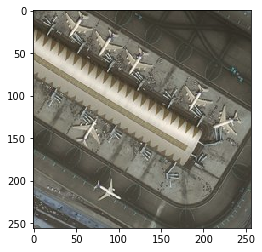

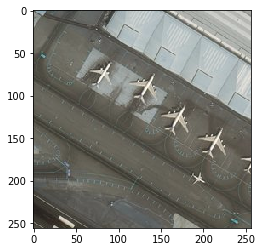

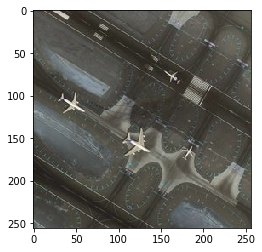

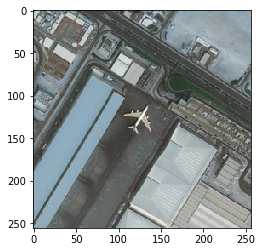

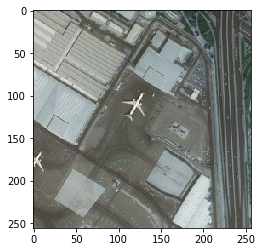

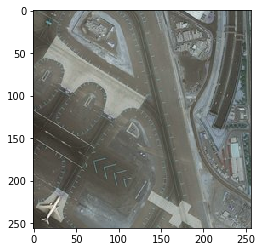

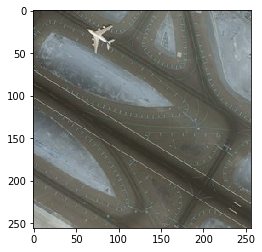

In [63]:
from keras.models import load_model

z=0

for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model.predict(img)
                if out[0][0] > 0.65:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)

In [35]:
model_name = 'airplain_vgg_custom_adam.h5' 
save_dir = os.getcwd()

print(os.getcwd())

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

C:\Users\cjung\jupiterNotebook\machine2020\homeworks\ML_final_exam\RCNN-master
Saved trained model at C:\Users\cjung\jupiterNotebook\machine2020\homeworks\ML_final_exam\RCNN-master\airplain_vgg_custom_adam.h5 
